In [7]:
from simulate import *

from datetime import datetime
from os import getcwd, makedirs, path
from shutil import copyfile
from time import time
from PIL import Image

from IPython.display import HTML


# Image preprocessing
binary_threshold = 10

# Connected components
connection_radius = 2

# Latice and region creation
lattice_radius = 50
lattice_stride = 50
min_component_size = 2

# Simulation
num_free_cells = 50
neighborhood = 1
max_iterations = 10
num_simulations = 100

# Meta
verbose = True

# image = Image.open("images/binary.jpg")
# image = Image.open("images/Cap-3-20x-vessels-blackandwhite.tif")
image = Image.open("images/Cap-2-vessels-blackandwhite-40X.tif")

%matplotlib inline

In [2]:
new_dirname = path.join(getcwd(), datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
makedirs(new_dirname)

# Copy the configuration file to the directory so that we can see
# the values that generated the outputs
copyfile("./configuration.py", path.join(new_dirname, "configuration.py"))

# Force the image to be square
# TODO: ask Ryan if we can expect most images to be about 512x512
square_image = image.resize((512, 512))

start = time()
binary_image = binarize_and_threshold_image(square_image, binary_threshold)
if verbose:
    print(binary_image.shape, binary_image.dtype)
    print(f"Time to binarize the input image: {time() - start:0.3f}s\n")

start = time()
adj_list = create_matrix_from_adjacency_list(binary_image, connection_radius)
if verbose:
    print("Number of vertices in graph:", len(adj_list))
    print(f"Time to create graph: {time() - start:0.3f}s\n")

start = time()
components = find_connected_compnents(adj_list)
num_components = len(components)
if verbose:
    print("Number of components:", num_components)
    print(f"Time to compute connected components: {time() - start:0.3f}s\n")

start = time()
lattice = create_lattice_of_component_counts(
    binary_image.shape,
    lattice_radius,
    lattice_stride,
    components,
    min_component_size,
)
if verbose:
    print(f"Time to create lattice: {time() - start:0.3f}s\n")

start = time()
brightness = get_brightnesses_from_image(square_image, lattice_stride)
regions = compute_region_scores(lattice, brightness)
if verbose:
    print(f"Time to create regions: {time() - start:0.3f}s\n")

# cell_grid, cell_anim = animate_cells(
#     num_free_cells, regions, max_iterations, neighborhood
# )

final_panes, animation_data = run_animations(
    regions,
    neighborhood,
    max_iterations,
    num_simulations,
    num_free_cells,
)

(512, 512) uint8
Time to binarize the input image: 0.001s

Number of vertices in graph: 262144
Time to create graph: 19.439s

Number of components: 39
Time to compute connected components: 0.929s

Time to create lattice: 1.785s

Time to create regions: 0.007s



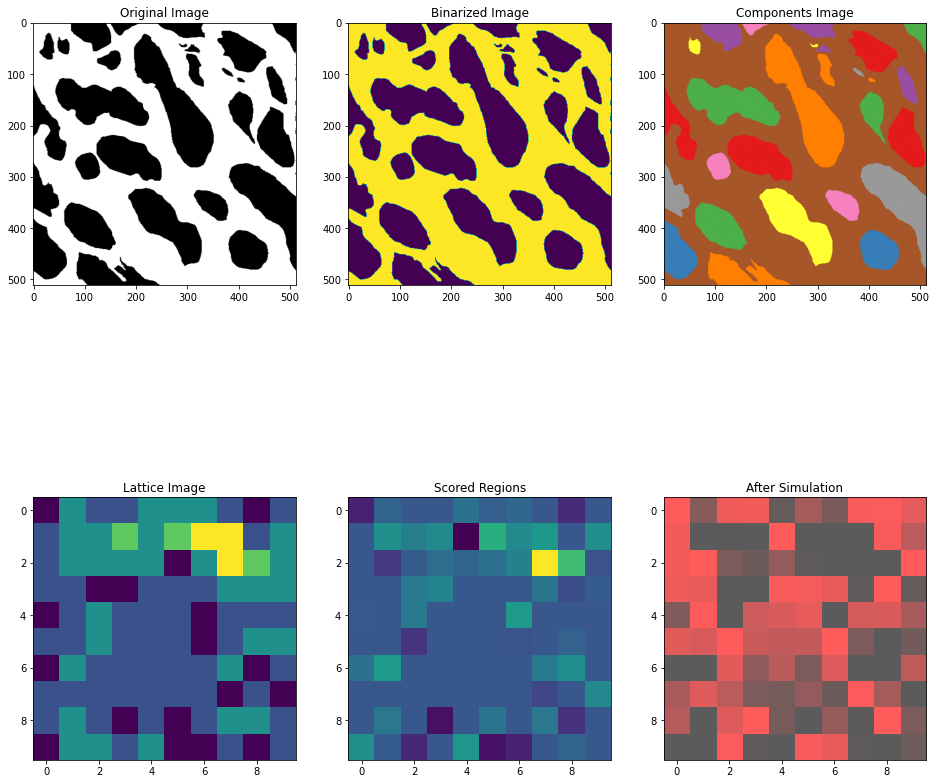

In [3]:
plot_figures(
    components,
    square_image,
    final_panes,
    binary_image,
    lattice,
    regions,
    new_dirname,
)

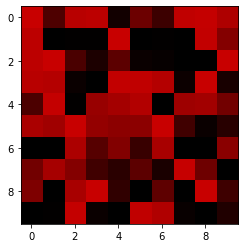

In [4]:
animation = generate_animation_image(animation_data, new_dirname);

In [8]:
HTML(animation.to_jshtml())